In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow.keras.metrics as metrics
from keras_tuner import Objective

2023-09-13 00:07:51.765837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("Resources/Aggregated_Metrics_By_Video.csv")
df

,Video,Video title,Video pub­lish time,Com­ments ad­ded,Shares,Dis­likes,Likes,Sub­scribers lost,Sub­scribers gained,RPM (USD),CPM (USD),Av­er­age per­cent­age viewed (%),Av­er­age view dur­a­tion,Views,Watch time (hours),Sub­scribers,Your es­tim­ated rev­en­ue (USD),Im­pres­sions,Im­pres­sions click-through rate (%)
0,Total,NaN,NaN,14197,39640,3902,225021,45790,229241,5.276,11.990,26.61,0:03:25,5568487,317602.3536,183451,29068.652,100954064,3.16
1,4OZip0cgOho,How I Would Learn Data Science (If I Had to St...,"May 8, 2020",907,9583,942,46903,451,46904,6.353,12.835,36.65,0:03:09,1253559,65850.7042,46453,7959.533,26498799,3.14
2,78LjdAAw0wA,100K Channel Update + AMA Stream!,"Nov 12, 2020",412,4,4,130,15,12,2.668,6.259,6.26,0:05:14,2291,200.2966,-3,6.113,188318,0.72
3,hO_YKK_0Qck,Uber Driver to Machine Learning Engineer in 9 ...,"Jul 16, 2020",402,152,15,881,9,198,9.516,11.695,15.12,0:10:21,21350,3687.3387,189,202.963,442334,2.53
4,uXLnbdHMf8w,Why I'm Starting Data Science Over Again.,"Aug 29, 2020",375,367,22,2622,40,1957,3.143,7.943,33.41,0:02:36,49564,2148.3110,1917,155.779,521185,4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,FBgs-BSTIJE,Demystifying Data Science Roles,"Nov 30, 2018",3,5,1,48,1,8,5.218,16.232,55.55,0:03:28,978,56.5930,7,5.103,26202,2.24
220,Yr5T3T4tq-g,Most Data Science Hopefuls Overlook This Impor...,"May 25, 2019",3,0,0,44,0,5,3.374,15.596,58.62,0:02:06,548,19.2752,5,1.849,21780,1.61
221,j-Z-je6K4Yg,IT'S NOT TOO LATE TO LEARN CODE!,"Dec 18, 2018",3,1,0,35,0,7,3.784,12.590,60.52,0:01:52,721,22.5450,7,2.728,18635,2.65
222,5jntoZX-Tc8,NASA Physicist Turned Data Scientist (Tim Bowl...,"May 5, 2019",2,5,0,38,0,3,2.651,12.206,16.93,0:03:09,1094,57.6363,3,2.900,34642,1.99


In [3]:
# Drop the header line
df = df.drop(labels = 0, axis = 0)

In [4]:
df = df.drop(['Video', 'Video title', 'Video pub\xadlish time', 'Sub\xadscribers lost', 
                        'Sub\xadscribers gained', 'Av\xader\xadage per\xadcent\xadage viewed (%)', 
                        'Av\xader\xadage view dur\xada\xadtion', 'Sub\xadscribers', 
                        'Your es\xadtim\xadated rev\xaden\xadue (USD)', 'Im\xadpres\xadsions', 
                        'Im\xadpres\xadsions click-through rate (%)'], axis=1)

In [5]:
#Fix the two columns with "\xad" in it before starting
df.rename(columns = {'Com\xadments ad\xadded':'Comments added', 'Dis\xadlikes':'Dislikes'}, inplace=True)

In [6]:
#Since there are only two nulls, we'll just remove those two rows.
df = df.dropna(axis=0)

In [7]:
df.isna().sum()

Comments added        0
Shares                0
Dislikes              0
Likes                 0
RPM (USD)             0
CPM (USD)             0
Views                 0
Watch time (hours)    0
dtype: int64

In [8]:
df.columns

Index(['Comments added', 'Shares', 'Dislikes', 'Likes', 'RPM (USD)',
       'CPM (USD)', 'Views', 'Watch time (hours)'],
      dtype='object')

In [9]:
y = df["RPM (USD)"]*df["Views"]/1000

In [10]:
df["CPM (USD)"] = df["CPM (USD)"]*df["Views"]/1000

In [11]:
X = df.drop(["RPM (USD)", "Views"], axis = 1)

In [12]:
X.rename(columns = {"CPM (USD)": "Cost"}, inplace = True)

In [13]:
X

,Comments added,Shares,Dislikes,Likes,Cost,Watch time (hours)
1,907,9583,942,46903,16089.429765,65850.7042
2,412,4,4,130,14.339369,200.2966
3,402,152,15,881,249.688250,3687.3387
4,375,367,22,2622,393.686852,2148.3110
5,329,118,15,590,99.710325,1034.3945
...,...,...,...,...,...,...
218,4,5,0,30,46.287850,9.6188
219,3,5,1,48,15.874896,56.5930
220,3,0,0,44,8.546608,19.2752
221,3,1,0,35,9.077390,22.5450


In [14]:
y.mean()

132.21318380542988

In [15]:
X.mean()

Comments added          63.968326
Shares                 179.298643
Dislikes                17.638009
Likes                 1017.316742
Cost                   298.928293
Watch time (hours)    1436.927080
dtype: float64

In [16]:
y.max()

7963.860326999999

In [17]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# find number of columns to find the input dimension
len(X.columns)

6

In [20]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = Sequential()

# First hidden layer
nn.add(Dense(units=8, activation="relu", input_dim=6))

# Second hidden layer
nn.add(Dense(units=8, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation='relu'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 56        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 137 (548.00 Byte)
Trainable params: 137 (548.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [22]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=150)

Epoch 1/150
6/6 [==============================] - 0s 2ms/step - loss: 428527.8125 - mean_squared_error: 428527.8125
Epoch 2/150
6/6 [==============================] - 0s 2ms/step - loss: 428525.3750 - mean_squared_error: 428525.3750
Epoch 3/150
6/6 [==============================] - 0s 2ms/step - loss: 428522.6250 - mean_squared_error: 428522.6250
Epoch 4/150
6/6 [==============================] - 0s 2ms/step - loss: 428519.4688 - mean_squared_error: 428519.4688
Epoch 5/150
6/6 [==============================] - 0s 2ms/step - loss: 428516.6562 - mean_squared_error: 428516.6562
Epoch 6/150
6/6 [==============================] - 0s 2ms/step - loss: 428513.3438 - mean_squared_error: 428513.3438
Epoch 7/150
6/6 [==============================] - 0s 2ms/step - loss: 428509.3750 - mean_squared_error: 428509.3750
Epoch 8/150
6/6 [==============================] - 0s 2ms/step - loss: 428506.0938 - mean_squared_error: 428506.0938
Epoch 9/150
6/6 [==============================] - 0s 2ms/step -

6/6 [==============================] - 0s 2ms/step - loss: 421859.0000 - mean_squared_error: 421859.0000
Epoch 71/150
6/6 [==============================] - 0s 2ms/step - loss: 421499.8438 - mean_squared_error: 421499.8438
Epoch 72/150
6/6 [==============================] - 0s 2ms/step - loss: 421165.7812 - mean_squared_error: 421165.7812
Epoch 73/150
6/6 [==============================] - 0s 2ms/step - loss: 420829.8125 - mean_squared_error: 420829.8125
Epoch 74/150
6/6 [==============================] - 0s 2ms/step - loss: 420625.4688 - mean_squared_error: 420625.4688
Epoch 75/150
6/6 [==============================] - 0s 2ms/step - loss: 420224.5000 - mean_squared_error: 420224.5000
Epoch 76/150
6/6 [==============================] - 0s 2ms/step - loss: 419772.0312 - mean_squared_error: 419772.0312
Epoch 77/150
6/6 [==============================] - 0s 2ms/step - loss: 419522.5625 - mean_squared_error: 419522.5625
Epoch 78/150
6/6 [==============================] - 0s 2ms/step - los

6/6 [==============================] - 0s 2ms/step - loss: 379530.9062 - mean_squared_error: 379530.9062
Epoch 140/150
6/6 [==============================] - 0s 2ms/step - loss: 378814.9688 - mean_squared_error: 378814.9688
Epoch 141/150
6/6 [==============================] - 0s 2ms/step - loss: 376993.7812 - mean_squared_error: 376993.7812
Epoch 142/150
6/6 [==============================] - 0s 2ms/step - loss: 375155.9375 - mean_squared_error: 375155.9375
Epoch 143/150
6/6 [==============================] - 0s 2ms/step - loss: 374009.2812 - mean_squared_error: 374009.2812
Epoch 144/150
6/6 [==============================] - 0s 2ms/step - loss: 372481.3125 - mean_squared_error: 372481.3125
Epoch 145/150
6/6 [==============================] - 0s 2ms/step - loss: 371265.5000 - mean_squared_error: 371265.5000
Epoch 146/150
6/6 [==============================] - 0s 1ms/step - loss: 370242.9375 - mean_squared_error: 370242.9375
Epoch 147/150
6/6 [==============================] - 0s 2ms/st

In [23]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 18105.7617 - mean_squared_error: 18105.7617 - 96ms/epoch - 48ms/step
Loss: 18105.76171875, Accuracy: 18105.76171875


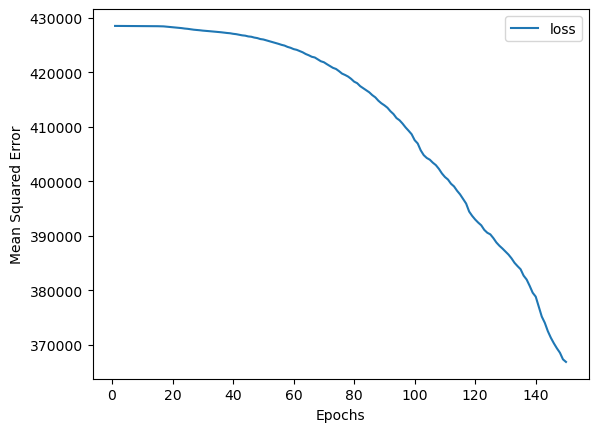

In [24]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.show()

In [25]:
# Evaluate the model using the test data
model_loss, model_percent_error = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Mean Absolute Percent Error: {model_percent_error}")

2/2 - 0s - loss: 18105.7617 - mean_squared_error: 18105.7617 - 19ms/epoch - 9ms/step
Loss: 18105.76171875, Mean Absolute Percent Error: 18105.76171875


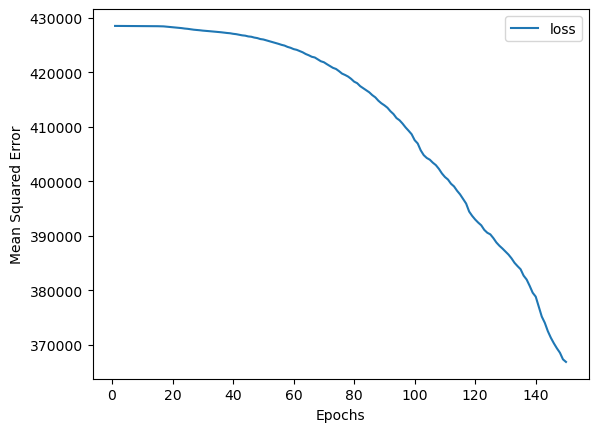

In [26]:
# Create a history dataframe
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.show()

In [27]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=15,
        step=5), activation=activation, input_dim=6))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 7)):
        nn_model.add(Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=15,
            step=5),
            activation=activation))

    nn_model.add(Dense(units=1, activation="relu"))

    # Compile the model
    nn_model.compile(loss="mean_squared_error", optimizer='adam',metrics = ['mean_squared_error'])

    return nn_model

In [28]:
# make a tuner object to find the best hyperparameters

tuner = kt.Hyperband(
    create_model,
    objective='mean_squared_error',
    max_epochs=200,
    hyperband_iterations=2)

In [29]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=200,validation_data=(X_test_scaled,y_test))

Trial 508 Complete [00h 00m 13s]
mean_squared_error: 427781.125

Best mean_squared_error So Far: 2807.855224609375
Total elapsed time: 00h 30m 57s
INFO:tensorflow:Oracle triggered exit


In [30]:
# Find the best model
top_model = tuner.get_best_models(1)[0]

model_loss = top_model.evaluate(X_test_scaled,y_test,verbose=1)
print(f"Loss: {model_loss}")

2/2 [==============================] - 0s 7ms/step - loss: 2249.4038 - mean_squared_error: 2249.4038
Loss: [2249.40380859375, 2249.40380859375]


In [31]:
# Find top model hyperparameters and print the values
top_hypers = tuner.get_best_hyperparameters(1)
for param in top_hypers:
    print(param.values)

{'activation': 'relu', 'first_units': 6, 'num_layers': 7, 'units_0': 6, 'units_1': 6, 'units_2': 11, 'units_3': 11, 'units_4': 6, 'units_5': 11, 'units_6': 11, 'tuner/epochs': 200, 'tuner/initial_epoch': 67, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0396'}


In [32]:
top_model.save("Revenue_prediction.h5")

/Users/Shadow/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
